Some initial imports, do **NOT** write any new code here:

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt


from datasets import load_dataset
from huggingface_hub import hf_hub_download

# Question 1: MRI Modality Translation (T1 → T2)

Magnetic Resonance Imaging (MRI) is a key modality for brain and brain tumour assessment. Different MRI contrasts highlight different tissue properties: for example, T1-weighted images provide good anatomical detail, while T2-weighted images are more sensitive to fluid and oedema, and often make tumour-related abnormalities more conspicuous. In clinical practice, not all contrasts are always acquired for every patient or every time point, and multi-contrast data can be incomplete or heterogeneous. Learning mappings between MRI modalities is therefore relevant for tasks such as image completion, protocol harmonisation, and data augmentation.

In this question you will work with a pre-processed dataset derived from a public brain tumour MRI collection. For each patient, paired **T1** and **T2** images have been extracted as **2D slices** from 3D volumes in several canonical views (axial, sagittal, coronal). The data have been co-registered, skull-stripped, and resampled to **single-channel 64×64** slices and split into **training** and **validation** sets. Each example includes:
- `patient_id`: an anonymised identifier for the patient  
- `split`: the dataset split (`train` or `validation`)  
- `view`: the anatomical view (`axial`, `sagittal`, or `coronal`)  
- `t1`: a 2D T1-weighted slice (shape `(1, 64, 64)`)  
- `t2`: the corresponding T2-weighted slice (same shape as `t1`)

Throughout this question, you will treat **T1 slices as inputs** and **T2 slices as targets** in an image-to-image regression setting.

This question is divided into three parts:

- **Part 1.A – Exploratory Data Analysis and Pre-processing**: you will inspect the dataset, develop simple visualisations, and design a basic intensity normalisation pipeline.  
- **Part 1.B – Modality Translation Model**: you will build and train a deep learning model that maps T1 slices to T2 slices, and evaluate its performance quantitatively and qualitatively.  
- **Part 1.C – Discussion**: you will critically reflect on your modelling choices, results, and limitations in a concise written analysis.

<br>

---

<br>

The next few blocks of code provided in the notebook will download and load the dataset from the Hugging Face Hub, and show you basic usage of the `datasets` API for accessing slices and metadata.


In [2]:
train_dataset = load_dataset("dpelacani/mri-t1-t2-2D-sliced-64", split="train")
valid_dataset = load_dataset("dpelacani/mri-t1-t2-2D-sliced-64", split="validation")

train_dataset, valid_dataset

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/711 [00:00<?, ?B/s]

data/train-00000-of-00004.parquet:   0%|          | 0.00/232M [00:00<?, ?B/s]

data/train-00001-of-00004.parquet:   0%|          | 0.00/223M [00:00<?, ?B/s]

data/train-00002-of-00004.parquet:   0%|          | 0.00/228M [00:00<?, ?B/s]

data/train-00003-of-00004.parquet:   0%|          | 0.00/243M [00:00<?, ?B/s]

data/validation-00000-of-00002.parquet:   0%|          | 0.00/175M [00:00<?, ?B/s]

data/validation-00001-of-00002.parquet:   0%|          | 0.00/183M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/116235 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/39375 [00:00<?, ? examples/s]

(Dataset({
     features: ['patient_id', 'split', 'view', 't1', 't2'],
     num_rows: 116235
 }),
 Dataset({
     features: ['patient_id', 'split', 'view', 't1', 't2'],
     num_rows: 39375
 }))

In [3]:
# Applying a transform to the dataset, this can also incluse torchvision transforms
def basic_transform_fn(sample_):
    if "t1" in sample_:
        sample_["t1"] = torch.tensor(sample_["t1"])
    if "t2" in sample_:
        sample_["t2"] = torch.tensor(sample_["t2"])
    return sample_

train_dataset = train_dataset.with_transform(basic_transform_fn)
valid_dataset = valid_dataset.with_transform(basic_transform_fn)

train_dataset[0]["t1"].shape, valid_dataset[0]["t1"].shape


(torch.Size([1, 64, 64]), torch.Size([1, 64, 64]))

<br><br>

## 1.A) Exploratory Data Analysis and Pre-processing

In this part you will carry out basic exploratory analysis of the paired T1/T2 slice dataset and design a simple pre-processing strategy that will be reused in Part 1.B.

Using the provided loading code and any helper functions you choose to implement, you should:

1. **Visualise representative T1–T2 pairs**  
   - For each anatomical view, plot a small grid of 8 T1/T2 pairs from the training set. Arrange the plots so that for each example the T1 input and its corresponding T2 target can be compared side-by-side (or in successive rows), and ensure that axes and titles are clearly labelled.

2. **Analyse intensity distributions**  
   - Plot histograms (or density plots) of pixel intensities for T1 and T2 slices, separately for the training and validation sets.  

3. **Design a simple intensity pre-processing transform**  
   - Based on your histograms of (2), propose and implement a basic normalisation scheme for `t1` and `t2` that is suitable for the task you will be carrying out in Part 1.B. For instance, you might try scaling the pixels to a fixed range such as \([0,1]\) or \([-1,1]\)) if you feel that is appropriate.

   - Apply this transform to the dataset and re-plot a few T1/T2 pairs and intensity histograms to verify that the transformed images are numerically well-behaved while preserving relevant anatomical structure.  


<br>

---

<br>

Write your answer to this question below. You can use as many code and text blocks as needed.

Please, **make sure to thoroughly describe and comment every piece of code that you include in your answer**. You will be expected to understand every line of code that you write.

<br>

1. **Visualise representative T1–T2 pairs**

In [31]:
sample0 = train_dataset[0]
# sample1 = train_dataset[1]

print("Keys:", sample0.keys())
print("patient_id:", sample0["patient_id"])
print("view:", sample0["view"])
print("t1 shape:", sample0["t1"].shape, "t2 shape:", sample0["t2"].shape)
print("t1 min/max:", sample0["t1"].min().item(), sample0["t1"].max().item())
print("t2 min/max:", sample0["t2"].min().item(), sample0["t2"].max().item())

Keys: dict_keys(['patient_id', 'split', 'view', 't1', 't2'])
patient_id: 083
view: axial
t1 shape: torch.Size([1, 64, 64]) t2 shape: torch.Size([1, 64, 64])
t1 min/max: 0.0 507.1000061035156
t2 min/max: 0.0 387.4375


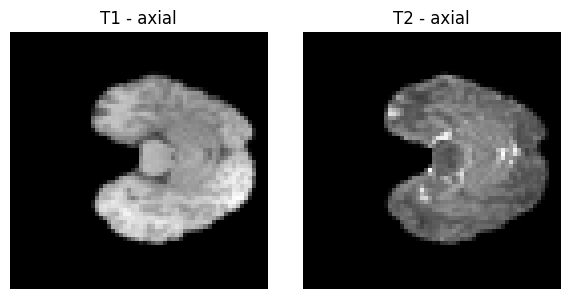

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

axes[0].imshow(sample1["t1"][0].numpy(), cmap="gray")
axes[0].set_title(f"T1 - {sample0['view']}")
axes[0].axis("off")

axes[1].imshow(sample0["t2"][0].numpy(), cmap="gray")
axes[1].set_title(f"T2 - {sample0['view']}")
axes[1].axis("off")

plt.tight_layout()
plt.show()

<br>

2. **Analyse intensity distributions**  

<br>

3. **Design a simple intensity pre-processing transform**

<br><br>

## 1.B) Modality Translation (T1 → T2)

In this part you will build an **image-to-image model** that takes a T1-weighted slice as input and predicts the corresponding T2-weighted slice. Each training example is therefore a pair $(\text{T1}, \text{T2})$ with matching spatial dimensions.

You are free to design the model architecture, but it must satisfy the following requirements:

- It should operate on 2D slices and produce an output with the **same spatial resolution** as the input
- It should take `t1` as input and learn to approximate `t2` as output, using the pre-processed data from Part 1.A.  

In designing your solution, you must determine:

- a **suitable architecture**, keeping in mind that simpler models should remain functional and that more complex designs may yield improved performance;  
- the **loss function** and **optimisation setup** you believe appropriate for this task;  
- the **evaluation strategy**, including at least one quantitative metric and the qualitative visualisation of predicted T2 images.

Key points to consider:

- You are expected to design the full solution **yourself**: the model, the preprocessing pipeline, and the overall training procedure. You must also decide on **suitable evaluation metrics** for this problem. **Strong solutions will ensure that the model can both preserve image quality and generalise well to the validation set.**

- Only include code that is necessary to reproduce your results. Notebook organisation and clarity form part of the assessment (see the main *README*).

- You should ensure that the notebook clearly displays example outputs of your **final trained model on the validation set**, as well as at least one plot showing how your chosen **evaluation metric(s) evolve over training iterations or epochs.**

- You may include **up to two** solutions in this notebook, in recognition that partially working attempts may still receive marks under the criteria outlined in the *README*, but you are encouraged to start with a simple, reliable baseline before attempting a more complex model.


<br>

---

<br>

Write your answer to this question below. You can use as many code and text blocks as needed.

Please, **make sure to thoroughly describe and comment every piece of code that you include in your answer**. You will be expected to understand every line of code that you write.

<br>

<br><br>

## 1.C) Discussion (max 250 words)

In this part you should provide a concise written discussion (maximum **250 words**) reflecting on your solution to Part 1.B. Your discussion should address the following points:

1. **Modelling choices and pre-processing**  
   Explain the main decisions behind your model architecture, loss function, and training strategy, and how they relate to the properties of the T1/T2 translation task.

2. **Performance and evaluation**  
   Interpret your **quantitative** results and **qualitative** reconstructions. Comment on how well your model appears to reconstruct `t2` features.

3. **Limitations and possible improvements**  
   Identify the main limitations of your current approach and outline concrete avenues for improvement. You may refer to alternative architectures, loss functions, or improved training and validation procedures.

Your answer should be technically focused, directly address these points, and remain within the stated word limit. Overly long or off-topic discussions will be penalised.


<br>

---

<br>

// Text answer

<br>

---

<br>